# Setup

In [2]:
%load_ext rpy2.ipython

import os
from json import loads as jloads
from glob import glob
import pandas as pd
import datetime

In [69]:
%%R

library(gplots)
library(ggplot2)
library(ggthemes)
library(reshape2)
library(gridExtra)
library(heatmap.plus)

ascols = function(facs, pallette){
    facs = facs[,1]
    ffacs = as.factor(as.character(facs))
    n = length(unique(facs))
    cols = pallette(n)[ffacs]
}

greyscale = function(n){
    return(rev(gray.colors(n)))
}

In [8]:
        
def getsname(filename):
    return filename.split('/')[-1].split('.')[0]


def readJSON(jsonf):
    return jloads(open(jsonf).read())


# Beta Diversity

In [27]:
obj = readJSON('results/olympiome.beta_diversity_stats.json.json')
speciesRhoKraken = obj['species']['rho_proportionality']['kraken']
speciesRhoKrakenDF = pd.DataFrame(speciesRhoKraken)
speciesJSDKraken = obj['species']['jensen_shannon_distance']['kraken']
speciesJSDKrakenDF = pd.DataFrame(speciesJSDKraken)

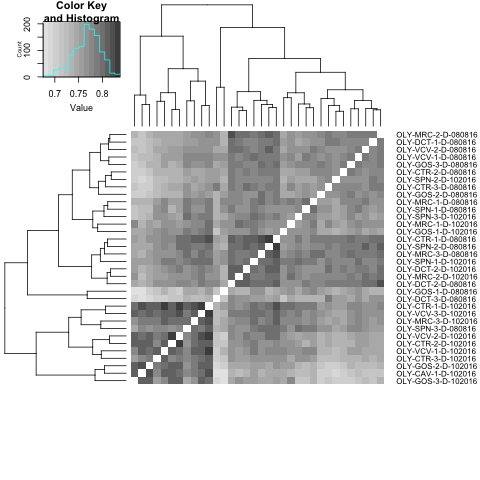

In [26]:
%%R -i speciesRhoKrakenDF 


beta.df = as.matrix(speciesRhoKrakenDF)
diag(beta.df) = NA

heatmap.2(beta.df, trace='none', margins=c(8,8), ColSideColorsSize=3, KeyValueName="Rho Prop.", labCol=F, cexRow=0.8, dendrogram="both", density.info="histogram", col=greyscale)

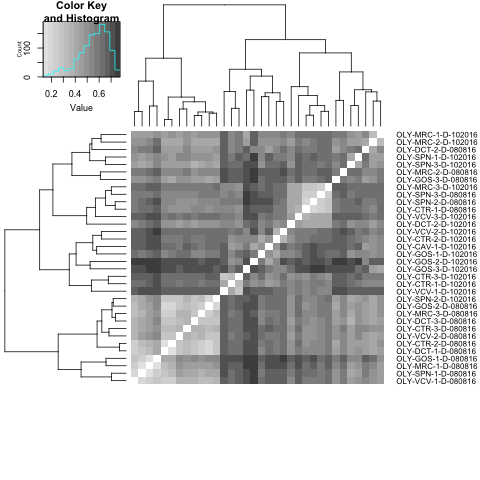

In [28]:
%%R -i speciesJSDKrakenDF 


beta.df = as.matrix(speciesJSDKrakenDF)
diag(beta.df) = NA

heatmap.2(beta.df, 
          trace='none', 
          margins=c(8,8), 
          ColSideColorsSize=3, 
          KeyValueName="Rho Prop.", 
          labCol=F, 
          cexRow=0.8, 
          dendrogram="both", 
          density.info="histogram", 
          col=greyscale)

# AMR

In [29]:
amrclassfs = glob('results/*.resistome_amrs.classus.tsv')

def parseF(fname):
    out = {}
    with open(fname) as f:
        f.readline()
        for line in f:
            tkns = line.strip().split('\t')
            out[tkns[1]] = int(tkns[2])
    return out

amrclass = {getsname(amrclassf): parseF(amrclassf) for amrclassf in amrclassfs}
amrclass = pd.DataFrame(amrclass).fillna(0).transpose()
amrclass.shape

(34, 18)

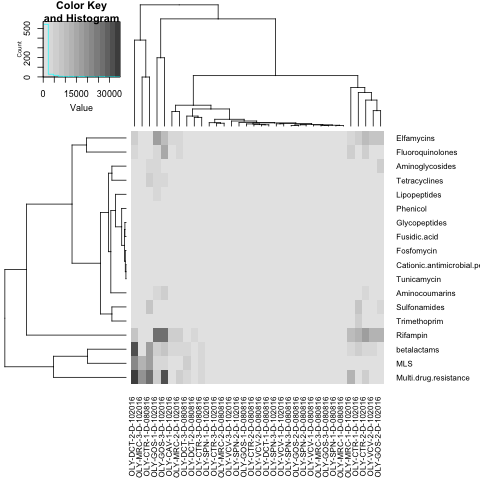

In [36]:
%%R -i amrclass 


amr.df = t(as.matrix(amrclass))


heatmap.2(amr.df, 
          trace='none', 
          margins=c(8,8), 
          ColSideColorsSize=3, 
          KeyValueName="Rho Prop.", 
          cexCol=0.8,
          cexRow=0.8, 
          dendrogram="both", 
          density.info="histogram", 
          col=greyscale)

# Virulence Factors

In [37]:
virfs = glob('results/*.vfdb_quantify.table.tsv')
virs = {getsname(virf): pd.read_csv(virf).set_index('Unnamed: 0').transpose() for virf in virfs}

virpan = pd.Panel(virs).transpose(2,0,1)
#vrpkm = virpan['RPKM'].fillna(0).apply(pd.to_numeric)
vrpkmg = virpan['RPKMG'].fillna(0).apply(pd.to_numeric)



In [60]:
vrpkmghigh = vrpkmg.transpose().loc[vrpkmg.mean(axis=0) > 200]
vrpkmghigh.shape

(25, 27)

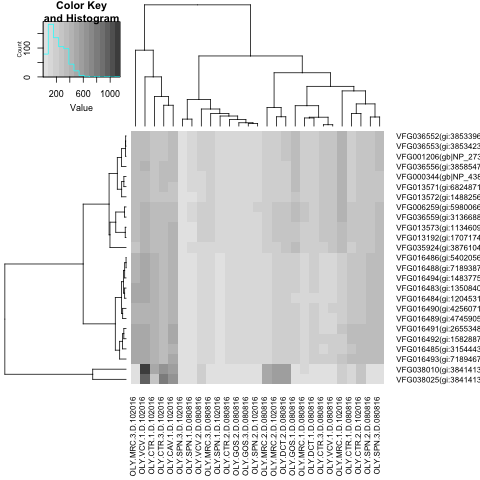

In [61]:
%%R -i vrpkmghigh 


vir.df = as.matrix(vrpkmghigh)


heatmap.2(vir.df, 
          trace='none', 
          margins=c(8,8), 
          ColSideColorsSize=3, 
          KeyValueName="Rho Prop.", 
          cexCol=0.8,
          cexRow=0.8, 
          dendrogram="both", 
          density.info="histogram", 
          col=greyscale)

# Virulence vs AMR

In [67]:
virlevels = vrpkmg.transpose().mean()
amrlevels = amrclass.transpose().mean().loc[virlevels.index]

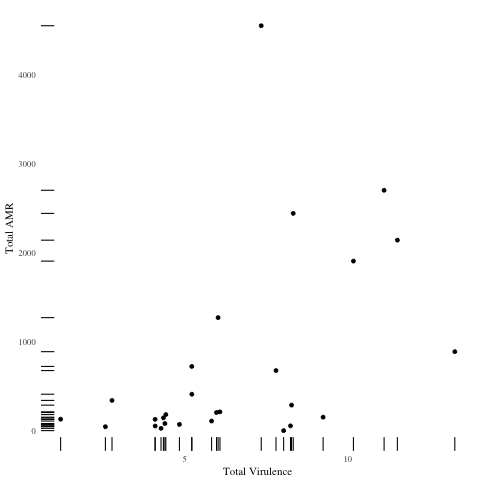

In [72]:
%%R -i virlevels -i amrlevels

df = cbind(virlevels, amrlevels)
colnames(df) = c("virulence", "antimicrobial")
df = as.data.frame(df)
ggplot(df, aes(virulence, antimicrobial)) + geom_point() + geom_rug() + theme_tufte(ticks=F) + 
  xlab("Total Virulence") + ylab("Total AMR") + 
  theme(axis.title.x = element_text(vjust=-0.5), axis.title.y = element_text(vjust=1))

# Alpha Diversity

In [73]:
adivfs = glob('results/*.alpha_diversity_stats.json.json')
adivs = {getsname(adivf): readJSON(adivf) for adivf in adivfs}

chaoSpecies = {}
shanSpecies = {}
richSpecies = {}
for sname, adiv in adivs.items():
    chaoSpecies[sname] = adiv['kraken']['species']['chao1']
    shanSpecies[sname] = adiv['kraken']['species']['shannon_index']
    richSpecies[sname] = adiv['kraken']['species']['richness']
    
chaoSpeciesDF = pd.DataFrame(chaoSpecies).fillna(0)
shanSpeciesDF = pd.DataFrame(shanSpecies).fillna(0)
richSpeciesDF = pd.DataFrame(richSpecies).fillna(0)

In [80]:
shanSpeciesDF.loc['500000'].sort_values()

OLY-GOS-2-D-102016    1.131420
OLY-GOS-1-D-080816    2.017785
OLY-VCV-1-D-102016    2.113828
OLY-CTR-3-D-102016    2.515238
OLY-CAV-1-D-102016    2.690970
OLY-MRC-1-D-080816    2.734370
OLY-GOS-3-D-102016    2.964415
OLY-CTR-1-D-102016    2.965770
OLY-MRC-3-D-102016    3.154512
OLY-MRC-2-D-080816    3.266224
OLY-SPN-3-D-080816    3.281402
OLY-SPN-1-D-080816    3.414872
OLY-SPN-1-D-102016    3.441151
OLY-VCV-3-D-102016    3.505264
OLY-SPN-3-D-102016    3.520592
OLY-MRC-1-D-102016    3.557303
OLY-GOS-1-D-102016    3.646314
OLY-VCV-1-D-080816    3.649548
OLY-GOS-3-D-080816    3.747699
OLY-CTR-2-D-102016    3.768835
OLY-CTR-1-D-080816    3.904346
OLY-SPN-2-D-080816    3.928825
OLY-DCT-2-D-080816    4.052498
OLY-VCV-2-D-102016    4.091087
OLY-DCT-2-D-102016    4.377253
OLY-MRC-2-D-102016    4.408525
OLY-DCT-1-D-080816    4.580841
OLY-CTR-3-D-080816    4.605533
OLY-CTR-2-D-080816    4.676267
OLY-VCV-2-D-080816    4.723607
OLY-MRC-3-D-080816    4.736393
OLY-SPN-2-D-102016    4.825670
OLY-DCT-

# HMP Comparison

In [85]:
hmpfs = glob('results/*.hmp_site_dists.metaphlan2.json')

def crunch(obj):
    out = {}
    for k, v in obj.items():
        out[k] = sum(v) / len(v)
    return out

hmps = {getsname(hmpf): crunch(readJSON(hmpf)) for hmpf in hmpfs}

hmps = pd.DataFrame(hmps).transpose()

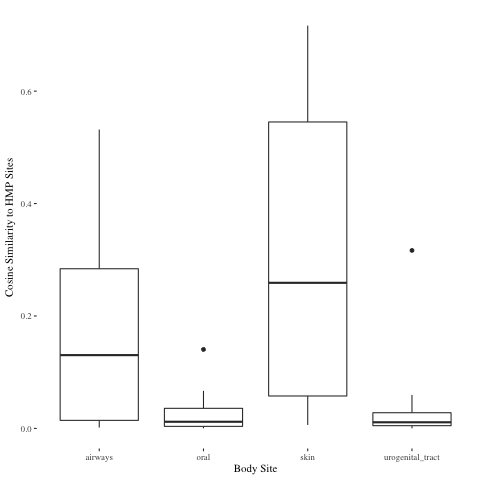

In [97]:
%%R -i hmps 

hmp.df = melt(hmps)

ggplot(hmp.df, aes(x=variable, y=value)) +
    theme_tufte() + 
    geom_boxplot() +
    ylab('Cosine Similarity to HMP Sites') +
    xlab('Body Site')

# Taxonomy

In [101]:
krakfs = glob('results/*.kraken_taxonomy_profiling.mpa.mpa.tsv')

def parseKrakF(krakf):
    out = {}
    with open(krakf) as kf:
        for line in kf:
            tkns = line.strip().split()
            taxa = tkns[0]
            if ('g__' in taxa) and ('s__' not in taxa):
                key = taxa.split('g__')[-1]
                out[key] = int(tkns[1])
    return out
            
    
def getTopN(vec, n):
    tups = vec.items()
    tups = sorted(tups, key=lambda x: -x[1])
    out = {k: v for k, v in tups[:n]}
    return out

krak10 = {getsname(krakf): getTopN(parseKrakF(krakf), 10) 
          for krakf in krakfs}
krak10 = pd.DataFrame(krak10).fillna(0).transpose()

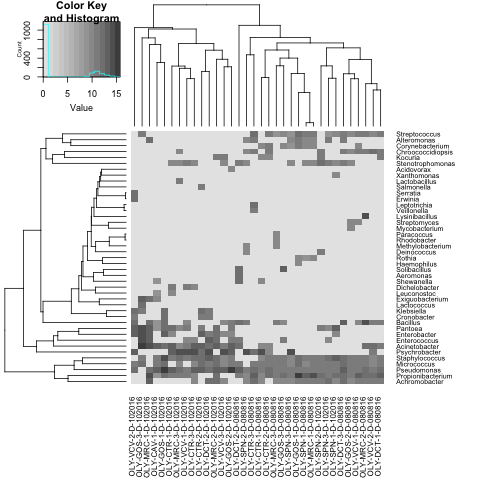

In [112]:
%%R -i krak10

krak.df = t(as.matrix(krak10))
krak.df = log(krak.df)
krak.df[!is.finite(krak.df)] = 0

heatmap.2(krak.df, 
          trace='none', 
          margins=c(8,8), 
          ColSideColorsSize=3, 
          KeyValueName="Rho Prop.", 
          cexCol=0.8,
          cexRow=0.7, 
          dendrogram="both", 
          density.info="histogram", 
          col=greyscale)